In [1]:
import pandas as pd
import numpy as np
from numpy.random import default_rng
from matplotlib import pyplot as plt

# Introduction
This notebook explores the classic percolation model for bushfire modelling and considers the Poisson distribution later.

In [2]:
def create_lattice(p, N, mode):
    rng = default_rng()
        
    if mode == 'bernoulli':
        x = rng.uniform(low=0, high=1, size=(N, N))
        y = x < p
    elif mode == 'poisson':
        y = rng.poisson(lam=p, size=(N, N))
    return y.astype(int)

# check if node contains fuel
def burnable(node, lattice):
    return lattice[node] > 0

# returns false if index is outside of lattice
def in_lattice(index, lattice):
    m, n = lattice.shape
    i, j = index
    if not 0 <= i <= m-1 or not 0 <= j <= n-1:
        return False
    else:
        return True

def get_neighbours(node, lattice):
    # get neighbours based on reach, i.e. node value
    # same for bernoulli and poisson modes, reach = L_inf distance
    nbs = []
    i, j = node
    reach = lattice[node]
#     k + l <= reach
    for k in range(reach + 1):
        for l in range(reach + 1 - k):
            for signk in [-1, 1]:
                for signl in [-1, 1]:
                    nb = (i + signk*k, j + signl* l)
                    if in_lattice(nb, lattice):
                        nbs.append(nb)
            
    # remove duplicates from k=0 or l=0
    nbs = list(set(nbs))
    # remove original node, case k=l=0
    if node in nbs:
        nbs.remove(node)
    return nbs
    
    

In [3]:
def simulate(p, N, mode):
    # initialize
    lattice = create_lattice(p, N, mode)
    matrices = [np.copy(lattice)]
    
    front = []
    archive = []
    
    # add burnable nodes in top row to front
    I, J = np.where(lattice[:1] > 0)
    for index in zip(I, J):
        front.append(index)
        
    # spread fire until front is emtpy
    while front:
        new_front = []
        
        for node in front:
            # get neighbours before burning
            nbs = get_neighbours(node, lattice)
            lattice[node] = -1
            
            # add burnable neighbours to new front
            for nb in nbs:
                if not nb in front and not nb in archive and burnable(nb, lattice):
                    new_front.append(nb)
        
        # update archive
        archive = archive + front
        # update front
        front = new_front
        
        # save snapshot of current lattice
        mat = np.copy(lattice)
        matrices.append(mat)
        
    return matrices

In [4]:
mats = simulate(.5, 30, 'bernoulli')

# Plotting and Animating

## Create Custom Color Map

### Bernoulli

The color map for the Bernoulli case should map:

- -1 (fire) to red
- 0 (no vegetation) to orange
- 1 (vegetation) to green

In [5]:
mats_bernoulli = simulate(0.5, 30, 'bernoulli')

In [6]:
from matplotlib import cm
from matplotlib import colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [7]:
red = np.array([colors.to_rgba('firebrick')])
brown = np.array([colors.to_rgba('orange')])
greens = cm.get_cmap('Greens', 256)



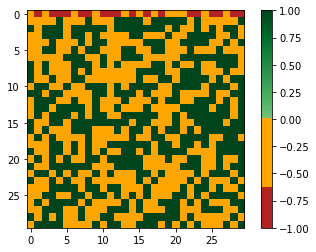

In [8]:
colors_bernoulli = greens(np.linspace(0, 1, 256))
colors_bernoulli[:48, :] = red
colors_bernoulli[48:129, :] = brown
cmp_bernoulli = ListedColormap(colors_bernoulli)

plt.imshow(mats_bernoulli[1], cmap = cmp_bernoulli, vmin = -1)
plt.colorbar()

### Poisson

For the Poisson case we want:

- -1 to red
- 0 to orange
- 1-10 to green, going from light green to dark green
 
Since in the last case we want gradient, it is easier to use a segmented color map and providing nodes for the gradient ranges.

Note: We assume in this notebook that values above 10 will rarely appear. If this does not hold, then the range has to be increased beyond 10. Larger values appear with bigger lattices but mostly with higher lambda. This is especially relevant for the masked lattice case where we allow for higher lambdas but use a Bernoulli mask to keep expected value small.

In [9]:
mats_poisson = simulate(0.5, 30, 'poisson')

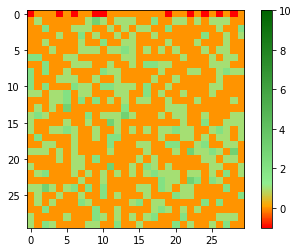

In [10]:
colors = ["red", "orange", "lightgreen", "darkgreen"]
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)

nodes = [0.0, 0.1, 0.2, 1.0]
cmp_poisson = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))


plt.imshow(mats_poisson[1], cmap = cmp_poisson, vmin = -1, vmax = 10)
plt.colorbar()

# Create Animation

In [11]:
from matplotlib.animation import FuncAnimation

In [12]:
import matplotlib.animation as animation
from IPython import display

In [13]:
def animate_grid(ls_mats, mode):
    if mode == 'bernoulli':
        cmap = cmp_bernoulli
        vmax = None
    elif mode == 'poisson':
        cmap  = cmp_poisson
        vmax = 10
    
    ims = []
    
    # plot in for parameter values .2, .4, .6, .8 in a 2x2 grid
    fig, ax = plt.subplots(2, 2)

In [80]:
def animate(mats, mode):
    
    if mode == 'bernoulli':
        cmap = cmp_bernoulli
        vmax = None
    elif mode == 'poisson':
        cmap  = cmp_poisson
        vmax = 10
        
    ims = []
    fig, ax = plt.subplots()
    
    for i, mat in enumerate(mats):
        im = plt.imshow(mat, cmap = cmap, vmin = -1, vmax=vmax, animated=True)

        if i==0:
            im = plt.imshow(mat, cmap = cmap, vmin = -1, vmax=vmax, animated=True)
            plt.colorbar()
        ims.append([im])
            
    anim = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                    repeat_delay=1000)
    plt.close()
    
    video = anim.to_html5_video()
    html = display.HTML(video)
    display.display(html)
    
# animate 4 cases of spreading in a 2x2 grid
def animate_22(ls_mats, mode):
    if len(ls_mats) != 4:
        print("Input must be a list with four matrix sequences")
        return
        
    if mode == 'bernoulli':
        cmap = cmp_bernoulli
        vmax = None
    elif mode == 'poisson':
        cmap  = cmp_poisson
        vmax = 10
        
    
    # pad matrices
    ls_mats_padded = pad_matrices(ls_mats)
    
    
    fig, ax = plt.subplots(2, 2)
    fig.subplots_adjust(hspace=0.5)
    
    ims = []
    for i in range(len(ls_mats_padded[0])):
        mat00 = ls_mats_padded[0][i]
        mat01 = ls_mats_padded[1][i]
        mat10 = ls_mats_padded[2][i]
        mat11 = ls_mats_padded[3][i]

#                 im = plt.imshow(mat, cmap = cmap, vmin = -1, vmax=vmax, animated=True)

            
        im00 = ax[0, 0].imshow(mat00, cmap=cmap, vmin=-1, vmax=vmax, animated=True)
        im01 = ax[0, 1].imshow(mat01, cmap=cmap, vmin=-1, vmax=vmax, animated=True)
        im10 = ax[1, 0].imshow(mat10, cmap=cmap, vmin=-1, vmax=vmax, animated=True)
        im11 = ax[1, 1].imshow(mat11, cmap=cmap, vmin=-1, vmax=vmax, animated=True)
        
        if i==0:
            im00 = ax[0, 0].imshow(mat00, cmap=cmap, vmin=-1, vmax=vmax, animated=True)
            im01 = ax[0, 1].imshow(mat01, cmap=cmap, vmin=-1, vmax=vmax, animated=True)
            im10 = ax[1, 0].imshow(mat10, cmap=cmap, vmin=-1, vmax=vmax, animated=True)
            im11 = ax[1, 1].imshow(mat11, cmap=cmap, vmin=-1, vmax=vmax, animated=True)
            fig.colorbar(im00, ax=ax, orientation='horizontal')
#             fig.colorbar(ax[0, 0], im00)

# fig.colorbar(images[0], ax=axs, orientation='horizontal', fraction=.1)
            
#                 if i==0:
#             im = plt.imshow(mat, cmap = cmap, vmin = -1, vmax=vmax, animated=True)
#             plt.colorbar()

        ims.append([im00, im01, im10, im11])

    anim = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                    repeat_delay=1000)
    plt.close()

    video = anim.to_html5_video()
    html = display.HTML(video)
    display.display(html)
    

def pad_matrices(ls_mats):

    max_length = max([len(mats) for mats in ls_mats])

    ls_mats_padded = [mats + [mats[-1]]*(max_length - len(mats)) for mats in ls_mats]
    
    return ls_mats_padded

In [84]:
np.arange(0.2, 1, step=.2)

array([0.2, 0.4, 0.6, 0.8])

In [88]:
mats20 = simulate(0.2, size, 'bernoulli')
mats40 = simulate(0.4, size, 'bernoulli')
mats60 = simulate(0.6, size, 'bernoulli')
mats80 = simulate(0.8, size, 'bernoulli')

animate(mats20, 'bernoulli')
animate(mats40, 'bernoulli')
animate(mats60, 'bernoulli')
animate(mats80, 'bernoulli')

In [87]:
size = 50
mats_bernoulli = [simulate(p, size, 'bernoulli') for p in np.arange(.2, 1, step=.2)]
animate_22(mats_bernoulli, 'bernoulli')


In [18]:
size = 50
mats_bernoulli = [simulate(p, size, 'poisson') for p in np.arange(.2, 1, step=.2)]
animate_22(mats_bernoulli, 'poisson')

mats20 = simulate(0.2, size, 'poisson')
mats40 = simulate(0.4, size, 'poisson')
mats60 = simulate(0.6, size, 'poisson')
mats80 = simulate(0.8, size, 'poisson')


animate(mats20, 'poisson')
animate(mats40, 'poisson')
animate(mats60, 'poisson')
animate(mats80, 'poisson')

# Data Analysis 

For site percolation we want to know how likely a fire is to reach the bottom side depending on p for Bernoulli, or lambda for Poisson.

In [ ]:
def reached_bottom(mat):
    fires = mat[-1:] == -1
    return fires.any()

def get_data(p, N, iterations, mode):
    df = pd.DataFrame([], columns=['p', 'crossing', 'mode'])
    for p in P:
        for i in range(iterations):
            mats = simulate(p, N, mode)
            new_row = {'p':p, 'crossing':reached_bottom(mats[-1]), 'mode':mode}
            df = df.append(new_row, ignore_index=True)
    return df

## Bernoulli

In [ ]:
iterations = 20
N = 50
P = np.linspace(0.1, 1, 20)
mode = 'bernoulli'
df = pd.DataFrame([], columns=['p', 'crossing', 'mode'])

df = get_data(p, N, iterations, mode)

In [ ]:
averages = df[['p', 'crossing']].groupby('p').mean()

averages['p'] = averages.index

plt.subplots()
plt.scatter('p', 'crossing', data=averages)
plt.xlabel('p')
plt.ylabel('crossing probability')

Instead of a steady increase with p, we see a sudden increase starting at the threshold around p = 0.5, as predicted by Percolation theory.

## Poisson

In [ ]:
iterations = 20
N = 50
P = np.linspace(0.1, 1, 20)
mode = 'poisson'
df = pd.DataFrame([], columns=['p', 'crossing', 'mode'])

df = get_data(p, N, iterations, mode)

In [ ]:
averages = df[['p', 'crossing']].groupby('p').mean()

averages['p'] = averages.index

plt.subplots()
plt.scatter('p', 'crossing', data=averages)
plt.xlabel('lambda')
plt.ylabel('crossing probability')

Similary to the Bernoulli case, here we see the same jump starting at same threshold lambda = 0.5. lambda and p are different parameters of two different distributions but connected as they are the expected value of their respective distributions.

# Masked distribution

As we have seen before 